In [3]:
%pip install streamlit

   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.1 MB ? eta -:--:--
   --- ------------------------------------ 0.8/9.1 MB 2.6 MB/s eta 0:00:04
   ---- ----------------------------------- 1.0/9.1 MB 2.1 MB/s eta 0:00:04
   ------ --------------------------------- 1.6/9.1 MB 1.9 MB/s eta 0:00:04
   --------- ------------------------------ 2.1/9.1 MB 2.1 MB/s eta 0:00:04
   ----------- ---------------------------- 2.6/9.1 MB 2.2 MB/s eta 0:00:04
   ------------- -------------------------- 3.1/9.1 MB 2.3 MB/s eta 0:00:03
   ---------------- ----------------------- 3.7/9.1 MB 2.2 MB/s eta 0:00:03
   ------------------- -------------------- 4.5/9.1 MB 2.4 MB/s eta 0:00:02
   ----------------------- ---------------- 5.2/9.1 MB 2.5 MB/s eta 0:00:02
   -------------------------- ------------- 6.0/9.1 MB 2.7 MB/s eta 0:00:02
   ---------------------------- ----------- 6.6/9.1 MB 2.7 MB/s eta 0:00:01
   -----------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


1. Live Detection Recognition

Load image, model and preprocess images

In [5]:
import os
import cv2
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import load_model
import pickle

conference_model = load_model('Conference.keras')

images_path = '5-People/' 

def load_images_from_folder(folder):
    images = []
    labels = []
    file_names = [f for f in os.listdir(folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    for filename in file_names:
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            images.append(img)
            labels.append(filename.split('_')[0])  
    return images, labels

def preprocess_images(images, size=(224, 224)):
    processed_images = []
    for img in images:
        resized_img = cv2.resize(img, size)
        blurred_img = cv2.GaussianBlur(resized_img, (5, 5), 0)
        gray_img = cv2.cvtColor(blurred_img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=3)
        sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
        normalized_img = cv2.normalize(sobel_magnitude, None, 0, 1, cv2.NORM_MINMAX)
        normalized_img_3channel = np.stack([normalized_img] * 3, axis=-1)
        processed_images.append(normalized_img_3channel)
    return np.array(processed_images)

Global and Local Feature Extraction (ORB)

In [6]:
def extract_conference_features(images, model):
    features = []
    preprocessed_images = preprocess_images(images)  
    for img in preprocessed_images:
        preprocessed_img = np.expand_dims(img, axis=0) 
        feature = model.predict(preprocessed_img)
        features.append(feature.flatten())
    return np.array(features)

def extract_orb_features(images):
    preprocessed_images = preprocess_images(images) 
    
    orb = cv2.ORB_create()
    descriptors = []
    for img in preprocessed_images:
        img_uint8 = (img * 255).astype(np.uint8) 
        gray_img = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
        _, des = orb.detectAndCompute(gray_img, None)
        descriptors.append(des)
    return descriptors

Saving and Loading Extracted Features

In [7]:
def save_features(global_features, global_labels, local_features, save_dir="features_cache_5"):
    os.makedirs(save_dir, exist_ok=True)
    np.savez(os.path.join(save_dir, "global_features.npz"), features=global_features, labels=global_labels)
    with open(os.path.join(save_dir, "local_features.pkl"), "wb") as f:
        pickle.dump(local_features, f)

def load_features(save_dir="features_cache_5"):
    global_data = np.load(os.path.join(save_dir, "global_features.npz"))
    global_features, global_labels = global_data["features"], global_data["labels"]
    with open(os.path.join(save_dir, "local_features.pkl"), "rb") as f:
        local_features = pickle.load(f)
    return global_features, global_labels, local_features

Global and Local Matching functions

In [8]:
def global_matching(query_feature, database_features, database_labels, top_k=5):
    similarities = cosine_similarity([query_feature], database_features)[0]
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    return [(database_labels[i], similarities[i]) for i in top_indices]

def local_matching(query_descriptors, candidate_descriptors):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches_per_candidate = []
    for des in candidate_descriptors:
        if des is None or query_descriptors is None:
            matches_per_candidate.append(0)
            continue
        matches = bf.match(query_descriptors, des)
        matches_per_candidate.append(len(matches))
    best_match_idx = np.argmax(matches_per_candidate)
    return best_match_idx, matches_per_candidate

Function for live detection

In [8]:
def live_detection(model, global_features, local_features, labels):
    cap = cv2.VideoCapture(0)
    orb = cv2.ORB_create()

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        processed_frame = preprocess_images([frame])[0]  

        processed_frame_uint8 = (processed_frame * 255).astype(np.uint8)

        query_global_feature = model.predict(np.expand_dims(processed_frame, axis=0)).flatten()

        frame_gray = cv2.cvtColor(processed_frame_uint8, cv2.COLOR_RGB2GRAY)
        _, query_local_descriptors = orb.detectAndCompute(frame_gray, None)

        top_candidates = global_matching(query_global_feature, global_features, labels, top_k=5)

        candidate_images_indices = [np.where(labels == label)[0][0] for label, _ in top_candidates]
        candidate_descriptors = [local_features[idx] for idx in candidate_images_indices]

        best_idx, matches_per_candidate = local_matching(query_local_descriptors, candidate_descriptors)

        best_match_label = labels[candidate_images_indices[best_idx]]
        cv2.putText(frame, f"Detected: {best_match_label}", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow("Live Detection", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


Main for live detection

In [9]:
if __name__ == "__main__":
    # images, labels = load_images_from_folder(images_path)

    # global_features = extract_conference_features(images, conference_model)

    # local_features = extract_orb_features(images)

    # save_features(global_features, labels, local_features)
    
    global_features, labels, local_features = load_features()

    live_detection(conference_model, global_features, local_features, labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━

In [11]:
import streamlit as st
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load pre-trained model and features
global_features, labels, local_features = load_features()
conference_model = load_model("Conference.keras")  # Load your actual model
orb = cv2.ORB_create()

def live_detection_streamlit():
    # Initialize webcam
    cap = cv2.VideoCapture(0)
    st.title("Live Detection System")
    st.text("Press 'Stop' to end the detection session.")

    # Streamlit image placeholder
    frame_placeholder = st.empty()

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            st.error("Failed to capture frame from webcam.")
            break

        # Preprocess the frame
        processed_frame = preprocess_images([frame])[0]  
        processed_frame_uint8 = (processed_frame * 255).astype(np.uint8)

        # Extract global feature
        query_global_feature = conference_model.predict(np.expand_dims(processed_frame, axis=0)).flatten()

        # Convert to grayscale and extract local features
        frame_gray = cv2.cvtColor(processed_frame_uint8, cv2.COLOR_RGB2GRAY)
        _, query_local_descriptors = orb.detectAndCompute(frame_gray, None)

        # Global feature matching
        top_candidates = global_matching(query_global_feature, global_features, labels, top_k=5)

        # Extract candidate descriptors
        candidate_images_indices = [np.where(labels == label)[0][0] for label, _ in top_candidates]
        candidate_descriptors = [local_features[idx] for idx in candidate_images_indices]

        # Local feature matching
        best_idx, matches_per_candidate = local_matching(query_local_descriptors, candidate_descriptors)

        # Get best match label
        best_match_label = labels[candidate_images_indices[best_idx]]

        # Annotate the frame
        cv2.putText(frame, f"Detected: {best_match_label}", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Display the annotated frame
        frame_placeholder.image(frame, channels="BGR")

        # Break the loop if Streamlit's "Stop" button is pressed
        if st.button("Stop"):
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    live_detection_streamlit()


2024-12-21 22:23:46.912 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:46.913 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:46.913 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:46.913 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:46.914 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:46.914 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2024-12-21 22:23:48.839 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:48.869 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:48.869 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:48.869 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:48.870 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:48.870 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:48.871 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:48.872 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:23:48.976 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:48.983 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:48.984 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:48.985 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:48.987 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:48.987 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:48.988 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:48.989 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


2024-12-21 22:23:49.102 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.111 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.112 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.112 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.113 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.113 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.114 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.114 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-12-21 22:23:49.216 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.224 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.225 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.225 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.226 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.226 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.227 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.227 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


2024-12-21 22:23:49.327 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.334 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.335 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.335 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.336 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.336 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.337 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.337 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


2024-12-21 22:23:49.436 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.442 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.442 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.442 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.442 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.444 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.444 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.444 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-12-21 22:23:49.549 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.555 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.556 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.557 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.557 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.558 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.559 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.559 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


2024-12-21 22:23:49.659 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.665 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.666 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.667 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.667 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.668 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.668 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.669 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


2024-12-21 22:23:49.773 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.778 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.778 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.778 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.779 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.779 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.779 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.780 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:23:49.889 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.897 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.898 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.899 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.899 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.900 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.900 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:49.901 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


2024-12-21 22:23:50.006 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.013 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.014 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.015 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.015 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.015 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.016 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.016 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


2024-12-21 22:23:50.134 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.141 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.141 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.142 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.142 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.142 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.142 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.142 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


2024-12-21 22:23:50.245 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.252 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.252 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.254 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.254 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.255 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.255 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.256 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


2024-12-21 22:23:50.361 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.368 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.368 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.369 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.369 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.369 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.370 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.370 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


2024-12-21 22:23:50.471 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.477 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.477 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.477 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.478 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.478 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.479 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.479 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:23:50.585 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.593 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.593 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.594 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.594 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.595 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.595 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.595 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


2024-12-21 22:23:50.698 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.706 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.706 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.707 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.707 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.708 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.709 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.709 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:23:50.814 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.824 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.824 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.825 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.827 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.827 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.828 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.828 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


2024-12-21 22:23:50.932 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.938 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.939 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.940 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.940 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.941 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.941 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:50.941 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


2024-12-21 22:23:51.042 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.048 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.049 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.049 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.050 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.050 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.051 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.052 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-12-21 22:23:51.166 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.172 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.172 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.172 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.173 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.173 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.174 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.175 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


2024-12-21 22:23:51.286 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.294 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.295 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.296 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.296 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.297 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.297 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.298 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


2024-12-21 22:23:51.401 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.407 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.407 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.407 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.407 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.407 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.408 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.408 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-12-21 22:23:51.514 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.522 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.522 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.523 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.523 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.524 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.525 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.526 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


2024-12-21 22:23:51.639 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.646 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.647 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.647 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.647 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.649 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.650 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.650 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:23:51.758 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.764 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.764 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.766 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.766 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.767 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.767 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.767 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


2024-12-21 22:23:51.875 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.882 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.882 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.883 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.883 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.884 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.885 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.885 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


2024-12-21 22:23:51.985 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.993 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.993 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.993 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.994 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.994 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.995 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:51.995 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


2024-12-21 22:23:52.097 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.103 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.104 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.104 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.106 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.107 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.107 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.108 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


2024-12-21 22:23:52.211 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.217 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.218 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.218 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.219 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.220 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.220 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.221 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


2024-12-21 22:23:52.329 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.335 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.336 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.337 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.338 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.338 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.339 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.340 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:23:52.446 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.454 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.455 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.456 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.457 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.458 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.459 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.460 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:23:52.579 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.587 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.588 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.588 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.589 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.589 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.590 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.590 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


2024-12-21 22:23:52.690 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.697 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.698 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.698 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.699 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.699 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.699 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.701 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


2024-12-21 22:23:52.805 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.811 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.812 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.812 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.813 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.813 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.814 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.814 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


2024-12-21 22:23:52.933 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.945 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.946 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.946 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.947 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.947 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.947 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:52.947 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


2024-12-21 22:23:53.061 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.066 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.067 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.067 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.068 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.069 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.069 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.070 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


2024-12-21 22:23:53.178 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.184 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.185 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.186 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.187 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.187 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.188 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.188 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


2024-12-21 22:23:53.300 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.307 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.308 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.309 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.310 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.310 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.311 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.312 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


2024-12-21 22:23:53.424 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.432 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.432 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.432 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.434 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.435 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.435 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.436 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


2024-12-21 22:23:53.562 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.569 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.569 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.569 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.570 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.571 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.572 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.572 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


2024-12-21 22:23:53.691 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.698 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.699 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.701 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.701 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.702 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.702 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.703 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


2024-12-21 22:23:53.817 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.825 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.826 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.827 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.828 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.828 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.829 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.830 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


2024-12-21 22:23:53.945 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.953 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.954 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.954 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.955 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.955 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.956 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:53.957 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


2024-12-21 22:23:54.080 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.087 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.087 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.088 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.089 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.089 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.089 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.090 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


2024-12-21 22:23:54.209 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.215 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.216 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.217 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.218 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.219 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.220 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.220 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


2024-12-21 22:23:54.336 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.346 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.347 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.348 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.348 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.349 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.349 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.350 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


2024-12-21 22:23:54.458 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.465 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.466 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.466 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.467 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.467 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.468 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.468 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


2024-12-21 22:23:54.591 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.598 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.599 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.600 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.600 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.601 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.602 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.602 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


2024-12-21 22:23:54.714 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.722 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.723 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.723 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.724 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.725 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.725 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.727 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


2024-12-21 22:23:54.847 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.857 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.858 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.859 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.859 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.860 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.860 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.861 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


2024-12-21 22:23:54.978 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.984 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.984 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.985 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.987 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.988 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.989 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:54.990 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


2024-12-21 22:23:55.107 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.114 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.115 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.115 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.116 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.117 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.119 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.119 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-12-21 22:23:55.227 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.232 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.234 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.235 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.235 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.236 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.237 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.237 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


2024-12-21 22:23:55.341 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.348 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.349 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.350 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.351 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.352 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.353 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.354 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-12-21 22:23:55.459 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.464 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.465 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.465 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.466 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.466 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.467 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.468 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


2024-12-21 22:23:55.569 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.580 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.580 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.582 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.582 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.583 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.584 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.584 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:23:55.687 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.693 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.694 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.695 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.695 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.696 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.697 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.697 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


2024-12-21 22:23:55.799 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.806 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.806 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.806 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.807 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.807 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.807 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.808 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:23:55.913 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.920 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.921 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.921 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.922 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.923 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.923 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:55.924 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


2024-12-21 22:23:56.026 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.032 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.033 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.033 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.033 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.034 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.034 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.035 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-12-21 22:23:56.141 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.146 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.147 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.147 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.147 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.149 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.150 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.151 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


2024-12-21 22:23:56.265 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.271 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.271 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.271 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.272 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.272 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.272 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.274 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


2024-12-21 22:23:56.372 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.378 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.379 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.380 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.380 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.381 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.381 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.381 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


2024-12-21 22:23:56.480 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.486 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.487 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.487 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.487 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.488 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.488 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.489 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


2024-12-21 22:23:56.595 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.600 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.601 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.601 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.601 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.601 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.602 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.602 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


2024-12-21 22:23:56.705 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.711 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.712 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.712 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.712 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.712 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.714 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.714 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:23:56.816 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.825 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.826 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.827 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.827 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.827 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.828 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.828 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


2024-12-21 22:23:56.929 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.934 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.935 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.935 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.936 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.937 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.937 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:56.938 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-12-21 22:23:57.052 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.059 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.060 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.060 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.061 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.061 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.061 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.062 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


2024-12-21 22:23:57.161 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.167 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.167 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.167 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.168 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.168 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.168 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.169 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


2024-12-21 22:23:57.272 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.278 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.279 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.279 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.280 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.281 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.281 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.281 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


2024-12-21 22:23:57.393 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.399 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.400 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.401 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.402 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.402 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.403 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.403 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


2024-12-21 22:23:57.509 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.516 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.516 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.517 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.517 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.519 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.520 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.521 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


2024-12-21 22:23:57.637 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.642 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.643 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.643 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.643 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.643 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.643 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.644 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-12-21 22:23:57.750 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.758 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.759 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.759 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.760 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.760 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.761 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.761 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


2024-12-21 22:23:57.862 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.868 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.869 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.869 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.870 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.870 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.871 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.871 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:23:57.977 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.983 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.984 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.984 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.985 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.986 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.986 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:57.987 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


2024-12-21 22:23:58.093 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.099 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.100 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.100 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.101 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.101 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.102 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.103 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-12-21 22:23:58.205 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.211 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.211 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.212 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.212 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.213 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.213 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.213 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


2024-12-21 22:23:58.321 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.329 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.329 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.330 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.330 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.330 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.331 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.331 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:23:58.434 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.440 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.441 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.441 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.441 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.442 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.442 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.443 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


2024-12-21 22:23:58.564 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.571 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.571 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.573 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.573 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.574 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.575 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.575 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


2024-12-21 22:23:58.681 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.688 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.689 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.690 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.691 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.692 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.692 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.693 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


2024-12-21 22:23:58.798 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.804 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.804 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.805 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.806 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.806 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.806 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.807 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


2024-12-21 22:23:58.917 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.925 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.926 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.926 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.927 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.927 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.928 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:58.929 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-12-21 22:23:59.033 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.040 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.041 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.041 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.041 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.042 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.042 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.043 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


2024-12-21 22:23:59.146 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.154 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.155 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.156 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.156 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.156 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.157 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.158 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


2024-12-21 22:23:59.266 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.272 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.273 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.273 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.273 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.274 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.274 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.274 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


2024-12-21 22:23:59.378 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.385 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.385 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.387 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.387 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.388 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.388 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.389 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:23:59.498 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.506 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.507 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.507 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.508 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.508 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.509 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.509 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


2024-12-21 22:23:59.615 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.624 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.625 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.625 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.626 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.627 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.627 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.627 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


2024-12-21 22:23:59.737 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.746 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.747 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.748 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.748 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.749 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.750 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.751 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


2024-12-21 22:23:59.875 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.882 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.882 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.884 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.884 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.885 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.886 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:23:59.886 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-12-21 22:24:00.003 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.010 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.011 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.012 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.013 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.013 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.014 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.014 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


2024-12-21 22:24:00.127 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.134 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.135 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.136 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.136 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.137 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.138 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.138 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-12-21 22:24:00.253 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.260 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.261 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.261 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.262 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.262 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.263 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.263 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-12-21 22:24:00.377 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.382 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.384 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.385 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.386 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.386 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.387 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.387 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-12-21 22:24:00.495 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.500 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.501 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.502 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.502 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.503 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.503 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.505 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


2024-12-21 22:24:00.616 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.624 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.625 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.625 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.625 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.625 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.627 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.627 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:24:00.734 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.741 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.741 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.742 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.742 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.742 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.743 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.743 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


2024-12-21 22:24:00.846 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.853 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.854 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.854 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.854 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.856 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.856 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.857 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


2024-12-21 22:24:00.960 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.966 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.966 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.967 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.967 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.968 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.969 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:00.970 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


2024-12-21 22:24:01.092 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.097 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.098 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.098 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.098 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.099 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.099 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.099 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


2024-12-21 22:24:01.203 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.209 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.210 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.210 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.210 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.211 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.211 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.211 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:24:01.315 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.323 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.323 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.323 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.324 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.324 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.324 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.325 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


2024-12-21 22:24:01.427 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.432 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.434 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.434 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.435 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.435 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.436 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.437 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:24:01.539 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.545 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.546 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.547 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.547 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.548 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.548 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.549 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:24:01.658 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.662 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.664 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.664 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.664 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.665 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.665 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.666 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


2024-12-21 22:24:01.774 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.780 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.780 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.780 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.780 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.780 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.782 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.783 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


2024-12-21 22:24:01.894 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.900 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.900 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.901 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.902 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.902 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.902 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:01.904 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


2024-12-21 22:24:02.011 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.019 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.020 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.021 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.022 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.022 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.023 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.023 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


2024-12-21 22:24:02.133 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.140 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.141 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.141 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.142 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.142 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.142 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.143 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


2024-12-21 22:24:02.250 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.258 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.259 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.259 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.260 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.261 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.263 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.264 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


2024-12-21 22:24:02.381 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.389 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.389 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.390 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.390 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.391 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.391 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.392 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


2024-12-21 22:24:02.499 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.506 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.507 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.507 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.508 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.508 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.508 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.509 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


2024-12-21 22:24:02.616 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.624 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.626 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.626 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.626 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.626 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.626 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.628 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


2024-12-21 22:24:02.734 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.741 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.742 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.743 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.743 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.744 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.744 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.744 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-12-21 22:24:02.853 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.860 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.861 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.861 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.862 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.863 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.863 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.864 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


2024-12-21 22:24:02.974 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.980 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.980 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.981 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.981 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.981 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.982 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:02.982 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


2024-12-21 22:24:03.093 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.098 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.099 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.100 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.100 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.101 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.101 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.102 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


2024-12-21 22:24:03.206 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.212 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.212 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.212 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.214 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.214 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.214 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.215 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


2024-12-21 22:24:03.326 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.331 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.332 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.332 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.333 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.333 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.334 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.334 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


2024-12-21 22:24:03.449 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.456 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.457 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.458 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.458 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.459 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.460 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.460 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


2024-12-21 22:24:03.574 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.580 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.580 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.581 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.581 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.582 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.583 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.584 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


2024-12-21 22:24:03.700 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.707 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.708 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.708 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.709 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.709 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.710 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.710 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


2024-12-21 22:24:03.827 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.833 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.833 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.834 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.834 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.835 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.835 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.837 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-12-21 22:24:03.940 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.945 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.946 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.946 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.947 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.947 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.947 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:03.949 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


2024-12-21 22:24:04.054 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.059 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.061 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.061 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.061 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.062 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.063 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.063 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


2024-12-21 22:24:04.170 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.176 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.176 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.177 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.177 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.177 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.178 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.178 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


2024-12-21 22:24:04.287 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.293 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.294 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.294 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.294 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.295 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.296 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.296 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


2024-12-21 22:24:04.406 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.412 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.412 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.413 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.414 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.414 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.415 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.416 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


2024-12-21 22:24:04.529 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.535 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.536 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.536 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.536 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.537 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.537 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.538 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-12-21 22:24:04.647 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.655 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.655 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.655 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.656 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.656 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.656 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.657 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:24:04.763 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.769 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.770 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.771 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.772 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.772 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.773 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.773 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


2024-12-21 22:24:04.890 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.897 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.897 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.897 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.897 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.898 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.898 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:04.899 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


2024-12-21 22:24:05.014 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.022 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.023 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.023 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.024 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.024 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.025 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.025 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


2024-12-21 22:24:05.133 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.141 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.142 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.142 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.143 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.143 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.144 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.144 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


2024-12-21 22:24:05.259 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.264 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.265 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.265 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.265 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.267 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.267 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.268 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


2024-12-21 22:24:05.383 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.391 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.392 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.392 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.393 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.393 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.393 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.394 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:24:05.502 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.508 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.508 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.509 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.510 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.510 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.512 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.512 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


2024-12-21 22:24:05.629 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.635 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.636 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.637 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.638 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.638 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.639 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.639 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


2024-12-21 22:24:05.757 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.763 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.764 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.764 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.764 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.765 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.766 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.766 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


2024-12-21 22:24:05.872 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.881 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.881 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.881 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.882 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.883 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.883 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:05.885 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:24:06.011 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.018 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.019 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.020 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.020 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.021 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.021 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.022 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


2024-12-21 22:24:06.123 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.128 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.129 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.130 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.131 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.131 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.132 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.132 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


2024-12-21 22:24:06.250 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.257 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.258 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.258 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.259 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.259 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.260 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.260 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


2024-12-21 22:24:06.362 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.367 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.367 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.369 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.369 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.370 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.370 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.370 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


2024-12-21 22:24:06.473 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.479 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.480 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.480 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.481 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.481 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.482 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.482 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:24:06.592 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.598 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.598 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.599 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.600 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.600 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.601 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.601 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


2024-12-21 22:24:06.713 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.720 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.721 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.721 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.722 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.722 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.723 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.723 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


2024-12-21 22:24:06.832 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.838 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.839 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.839 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.840 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.840 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.841 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.841 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-12-21 22:24:06.954 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.961 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.962 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.963 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.963 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.964 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.965 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:06.965 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:24:07.073 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.080 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.081 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.082 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.082 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.083 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.084 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.084 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:24:07.194 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.200 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.200 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.201 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.202 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.202 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.204 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.204 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-12-21 22:24:07.328 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.334 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.334 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.335 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.336 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.337 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.338 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.340 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


2024-12-21 22:24:07.459 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.465 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.466 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.466 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.467 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.467 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.468 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.469 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2024-12-21 22:24:07.579 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.586 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.587 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.588 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.588 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.589 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.589 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.589 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


2024-12-21 22:24:07.699 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.706 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.707 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.708 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.708 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.709 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.709 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.710 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


2024-12-21 22:24:07.814 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.820 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.822 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.822 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.822 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.824 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.824 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.824 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


2024-12-21 22:24:07.932 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.939 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.940 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.941 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.941 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.941 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.942 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:07.942 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


2024-12-21 22:24:08.045 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:08.052 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:08.052 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:08.053 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:08.054 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:08.055 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:08.056 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:08.057 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


2024-12-21 22:24:08.164 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:08.171 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:08.172 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:08.173 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:08.173 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:08.173 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:08.174 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-21 22:24:08.175 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

KeyboardInterrupt: 

2. Image Recognition 

Libraries

In [7]:
import os
import glob
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

Load InceptionV3 model

In [8]:
conference_model = load_model('Conference.keras')

Load features function

In [9]:
def load_features(save_dir="features_cache_5"):
    global_data = np.load(f"{save_dir}/global_features.npz")
    global_features, global_labels = global_data["features"], global_data["labels"]
    with open(f"{save_dir}/local_features.pkl", "rb") as f:
        local_features = pickle.load(f)
    return global_features, global_labels, local_features

Matching Function

In [10]:
def global_matching(query_feature, database_features, database_labels, top_k=5):
    similarities = cosine_similarity([query_feature], database_features)[0]
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    return [(database_labels[i], similarities[i]) for i in top_indices]

def local_matching(query_descriptors, candidate_descriptors):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches_per_candidate = []
    for des in candidate_descriptors:
        if des is None or query_descriptors is None:
            matches_per_candidate.append(0)
            continue
        matches = bf.match(query_descriptors, des)
        matches_per_candidate.append(len(matches))
    best_match_idx = np.argmax(matches_per_candidate)
    return best_match_idx, matches_per_candidate

Handling query image matching

In [11]:
def extract_orb_features(image):
    orb = cv2.ORB_create()
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, descriptors = orb.detectAndCompute(gray_img, None)
    return descriptors

def preprocess_query_image(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    resized_img = cv2.resize(img_rgb, (224, 224))
    
    blurred_img = cv2.GaussianBlur(resized_img, (5, 5), 0)
    
    gray_img = cv2.cvtColor(blurred_img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=3)
    sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    normalized_img = cv2.normalize(sobel_magnitude, None, 0, 1, cv2.NORM_MINMAX)
    
    normalized_img_3channel = np.stack([normalized_img] * 3, axis=-1)
    
    normalized_img_3channel = (normalized_img_3channel * 255).astype(np.uint8)
    model_input = np.expand_dims(normalized_img_3channel, axis=0) / 255.0  
    
    return img_rgb, model_input

def group_images_by_label(labels):
    grouped = defaultdict(list)
    for idx, label in enumerate(labels):
        grouped[label].append(idx)
    return grouped

def find_best_match_across_all(query_feature, query_descriptors, grouped_indices, global_features, global_labels, local_features, top_k=5):
    best_overall_match = None
    highest_similarity = -1
    
    for label, indices in grouped_indices.items():
        person_features = global_features[indices]
        person_labels = [global_labels[idx] for idx in indices]
        person_local_features = [local_features[idx] for idx in indices]
        
        top_matches = global_matching(query_feature, person_features, person_labels, top_k=top_k)
        
        candidate_descriptors = person_local_features
        best_local_idx, _ = local_matching(query_descriptors, candidate_descriptors)
        
        best_match_label = person_labels[best_local_idx]
        
        for best_match in top_matches:
            if best_match[0] == best_match_label:
                if best_match[1] > highest_similarity:
                    highest_similarity = best_match[1]
                    best_overall_match = best_match
    
    return best_overall_match

Display Result Function

In [12]:
def display_query_and_best_match(query_image, best_match, image_dir="5-People/"):
    matched_label, similarity = best_match

    matched_files = glob.glob(f"{image_dir}/{matched_label}_*.jpg")
    if not matched_files:
        print(f"Error: No image found for label '{matched_label}'")
        return

    matched_image_path = matched_files[0]  
    matched_image = cv2.imread(matched_image_path)
    matched_image_rgb = cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(11, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(query_image)
    plt.title("Query Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(matched_image_rgb)
    plt.title(f"Best Match: {matched_label}\nSim: {similarity:.2f}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

Image Recognition Main

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


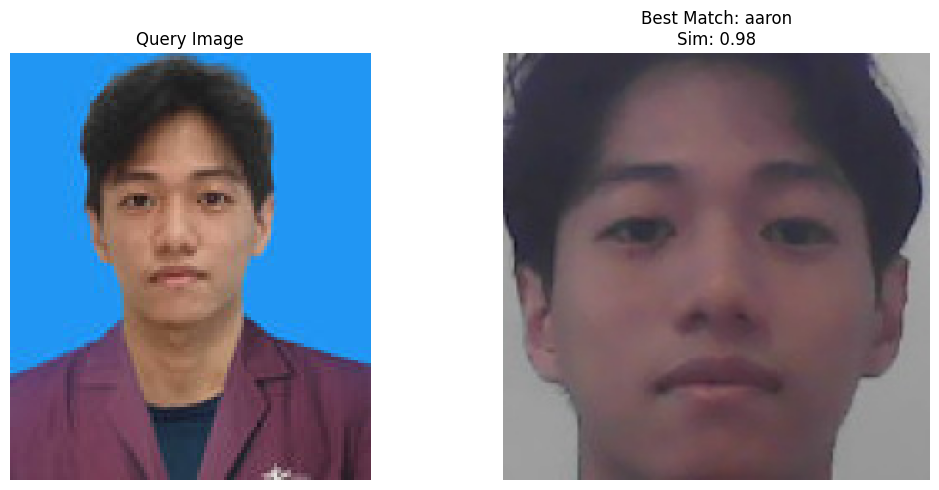

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


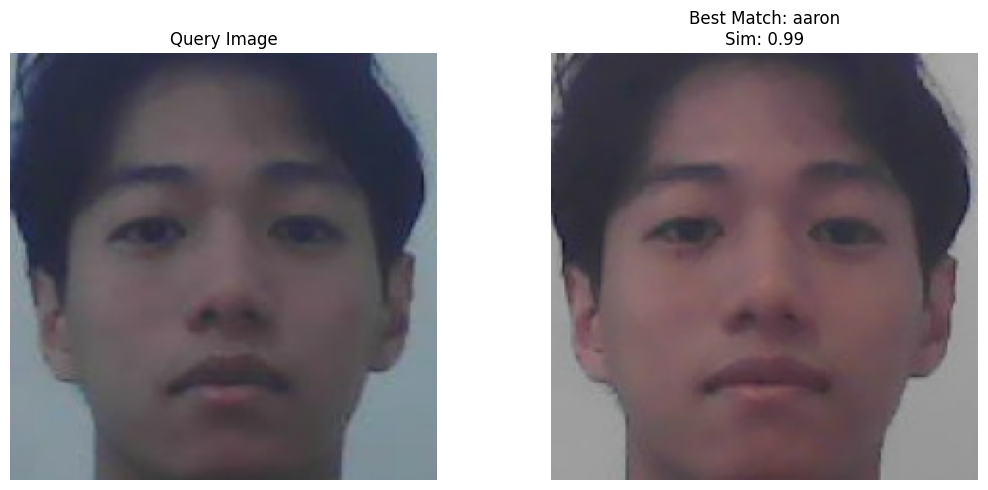

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


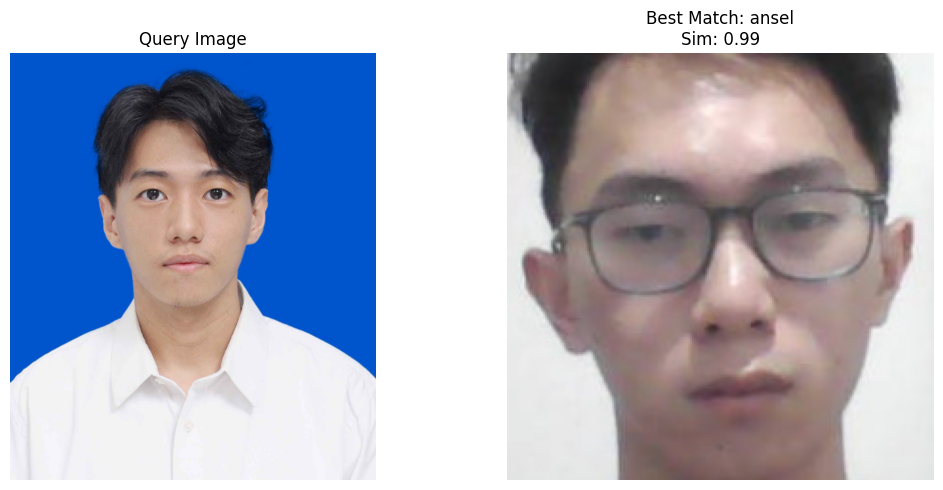

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


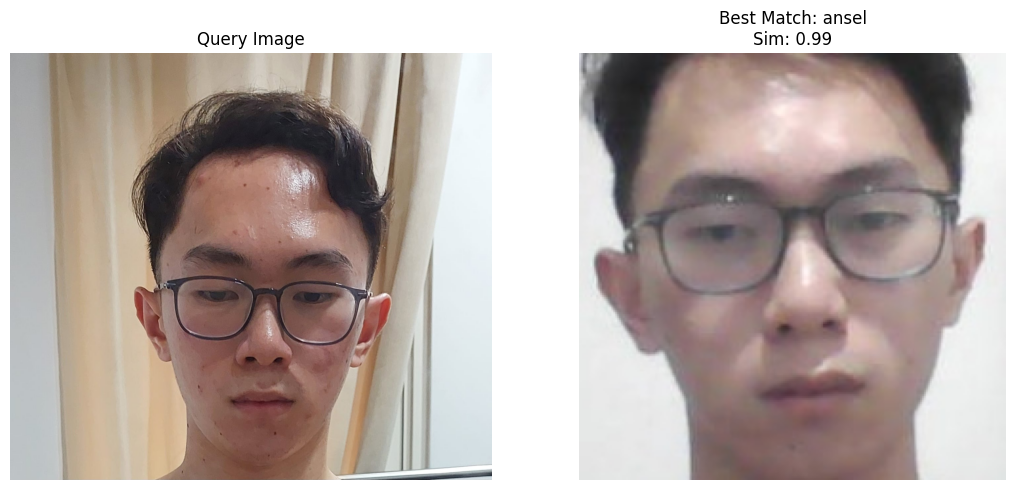

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


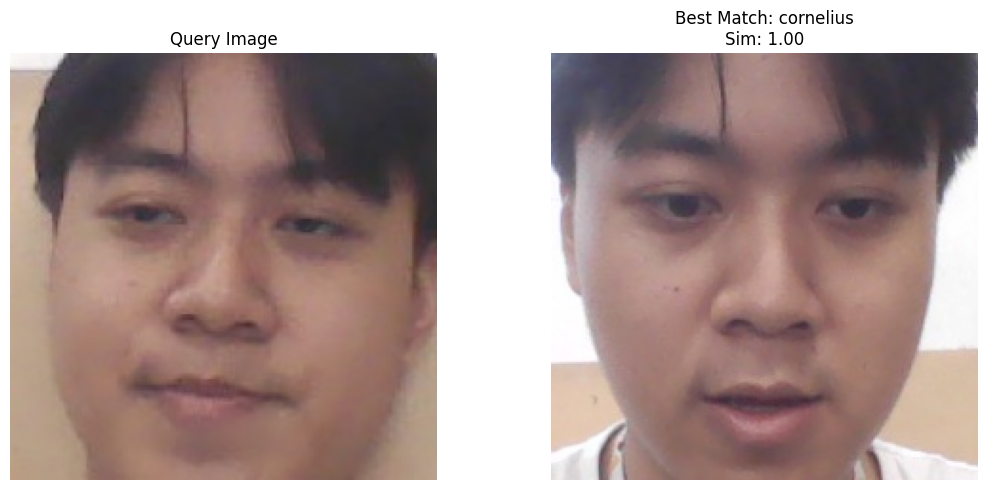

In [13]:
if __name__ == "__main__":
    global_features, labels, local_features = load_features()

    query_image_path = "BINUS-MAYA/" 

    for img in os.listdir(query_image_path):
        true_path = os.path.join(query_image_path, img)

        if not img.lower().endswith(('.jpg', '.jpeg', '.png')):
            print(f"Skipping non-image file: {true_path}")
            continue

        try:
            query_image, preprocessed_query_image = preprocess_query_image(true_path)

            query_global_feature = conference_model.predict(preprocessed_query_image).flatten()

            query_local_descriptors = extract_orb_features(query_image)

            grouped_indices = group_images_by_label(labels)

            best_match = find_best_match_across_all(query_global_feature, query_local_descriptors, grouped_indices, global_features, labels, local_features)

            display_query_and_best_match(query_image, best_match)

        except Exception as e:
            print(f"Error processing file {true_path}: {e}")
